# CESM-LE light variables

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_150m','SHF_QSW','Jint_100m_DIC','Jint_100m_Fe','spC_zint','diatC_zint'] #,'Jint_100m_DIC','Fe_FLUX_IN_100m']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

Fe_avg_150m
SHF_QSW
Jint_100m_DIC
Jint_100m_Fe
spC_zint
diatC_zint
CPU times: user 434 ms, sys: 60 ms, total: 494 ms
Wall time: 895 ms


In [3]:
ds.time

<xarray.DataArray 'time' (time: 181)>
array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027,
       2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039,
       2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075,
       2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087,
       2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099,
       2100])
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100

In [4]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_FLUX_IN_100m']

ds_list = []
ds2 = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds2 = xr.merge((ds2, dsv))
    ds_list.append(ds2)

Fe_FLUX_IN_100m
CPU times: user 14.9 ms, sys: 830 µs, total: 15.7 ms
Wall time: 54.6 ms


In [5]:
ds2['time'] = ds['time']

In [6]:
ds = xr.merge((ds, ds2))

### Fix units

In [7]:
nmol_cm2_s_to_nmol_m2_d = 10000. * 86400.
ds['Fe_FLUX_IN_100m'] = ds['Fe_FLUX_IN_100m'] * nmol_cm2_s_to_nmol_m2_d
ds.Fe_FLUX_IN_100m.attrs['units'] = 'nmol/m^2/d'

In [8]:
convert = 0.01 * 86400.
ds['NCP'] = (-1.) * ds.Jint_100m_DIC * convert
ds.NCP.attrs = ds.Jint_100m_DIC.attrs
ds.NCP.attrs['units'] = 'mmol/m^2/d'

In [9]:
convert = 0.01 * 86400.
ds['Bio_Fe_uptake'] = (-1.) * ds.Jint_100m_Fe * convert
ds.Bio_Fe_uptake.attrs = ds.Jint_100m_Fe.attrs
ds.Bio_Fe_uptake.attrs['units'] = 'mmol/m^2/d'

In [10]:
variables = ['Fe_avg_150m','SHF_QSW','NCP','Fe_FLUX_IN_100m','Bio_Fe_uptake']

### Necessary plotting function

In [11]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### get pop grid

In [12]:
grid = pop_tools.get_grid('POP_gx1v6')

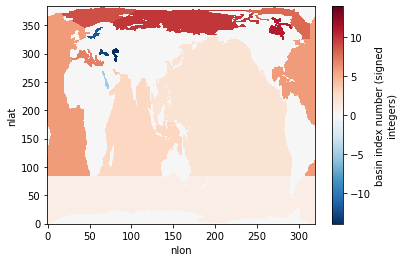

In [13]:
grid.REGION_MASK.plot()

In [14]:
lons = grid.TLONG
lats = grid.TLAT
area = grid.TAREA
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [15]:
ds = ds.where(grid.REGION_MASK>0)

### extract 1920s

In [16]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [17]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### extract 1990s

In [18]:
ds.time.isel(time=slice(70,80)).values

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [19]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [20]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [21]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

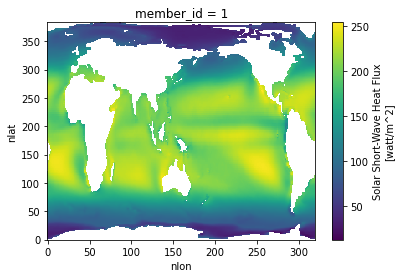

In [22]:
ds_2090s.SHF_QSW.isel(member_id=0).plot()

### calculate ensemble means

In [23]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_1990s = ds_1990s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

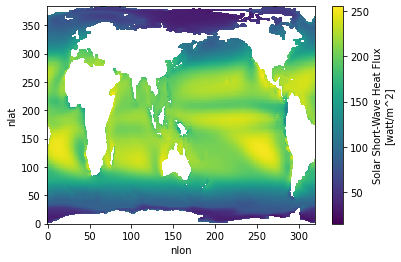

In [24]:
ensemble_mean_2090s.SHF_QSW.plot()

## change in surface Shortwave

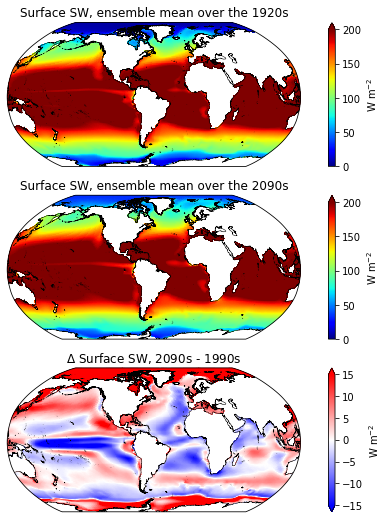

In [25]:
fig = plt.figure(figsize=(10,9))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_1990s['SHF_QSW'])

ax.set_title('Surface SW, ensemble mean over the 1920s', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=200,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='W m$^{-2}$')

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_2090s['SHF_QSW'])

ax.set_title('Surface SW, ensemble mean over the 2090s', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=200,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='W m$^{-2}$')

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_2090s['SHF_QSW'] - ensemble_mean_1990s['SHF_QSW'])

ax.set_title('${\Delta}$ Surface SW, 2090s - 1990s', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-15,vmax=15,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='W m$^{-2}$')

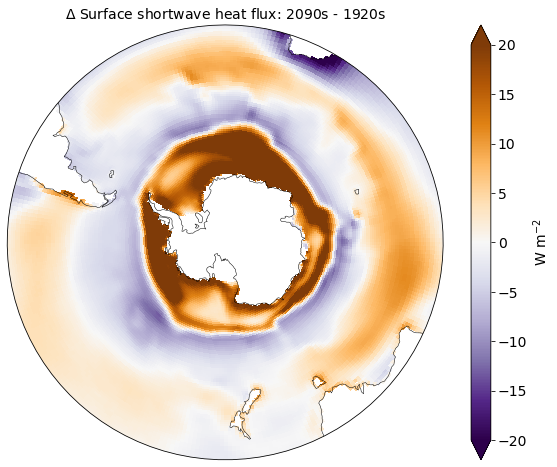

In [26]:
fig = plt.figure(figsize=(10,8))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_2090s['SHF_QSW'] - ensemble_mean_1920s['SHF_QSW'])
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('${\Delta}$ Surface shortwave heat flux: 2090s - 1920s', fontsize=14)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-20, vmax=20, 
                 cmap='PuOr_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='W m$^{-2}$',size=14)
cbar1.ax.tick_params(labelsize=14)

#fig.savefig('/glade/work/kristenk/figs/change_in_SWsurf_SO.png', bbox_inches='tight', dpi=300, format='png');

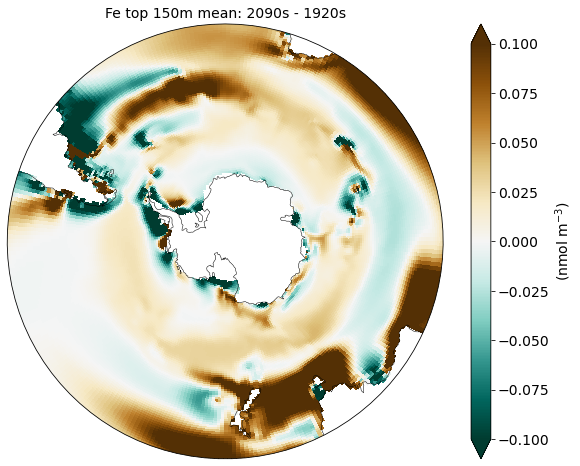

In [27]:
fig = plt.figure(figsize=(10,8))
#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, (ensemble_mean_2090s.Fe_avg_150m- ensemble_mean_1920s.Fe_avg_150m) * 1000.)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Fe top 150m mean: 2090s - 1920s',fontsize=14)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, 
                 vmin=-0.1, vmax=0.1, 
                 #vmin=0.000001,vmax=0.0001,
                 cmap='BrBG_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='(nmol m$^{-3}$)',size=14)
cbar1.ax.tick_params(labelsize=14)

#fig.savefig('/glade/work/kristenk/figs/change_in_Fe_mean_150m.png', bbox_inches='tight', dpi=300, format='png');

## make zonal means of SW and Fe change

In [24]:
zonal_1920s = ensemble_mean_1920s.isel(nlat=slice(0,93)).mean(dim='nlon')
zonal_1990s = ensemble_mean_1990s.isel(nlat=slice(0,93)).mean(dim='nlon')
zonal_2090s = ensemble_mean_2090s.isel(nlat=slice(0,93)).mean(dim='nlon')
lats_zonal = lats.isel(nlat=slice(0,93)).mean(dim='nlon')

In [25]:
zonal_1920s

<xarray.Dataset>
Dimensions:          (nlat: 93, z_t: 60)
Dimensions without coordinates: nlat, z_t
Data variables:
    KMT              (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    TAREA            (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    dz               (z_t, nlat) float32 dask.array<chunksize=(60, 93), meta=np.ndarray>
    Fe_avg_150m      (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    SHF_QSW          (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    Jint_100m_DIC    (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    Jint_100m_Fe     (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    spC_zint         (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    diatC_zint       (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    Fe_FLUX_IN_100m  (nlat) float32 dask.array<chunksize=(93,), meta=np.ndarray>
    NCP              (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    Bio_Fe_uptake    (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>

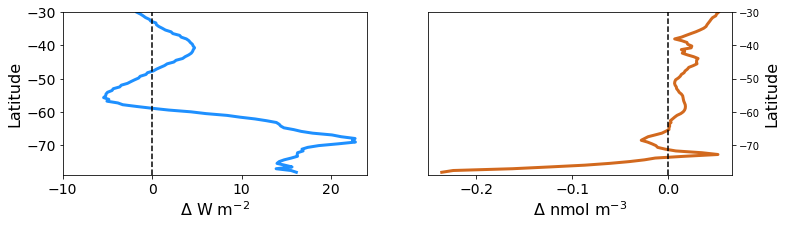

In [26]:
fig = plt.figure(figsize=(12,3))

### SW light
ax = fig.add_subplot(1,2,1)

ax.set_ylim(-79,-30)
ax.set_xlim(-10,24)
#ax.set_title('b)${\Delta}$ Change diatom fraction', x=0.4)
#ax.plot(zonal_1990s['diat_frac']-zonal_1920s['diat_frac'],lats_zonal,  label='1990s', linewidth=3)
ax.plot(zonal_2090s['SHF_QSW']-zonal_1920s['SHF_QSW'],lats_zonal,  label='surface SW', linewidth=3, color='dodgerblue')
plt.axvline(x=0,color='black',linestyle='--')
ax.set_ylabel(ylabel='Latitude',fontsize=16)
ax.set_xlabel(xlabel='${\Delta}$ W m$^{-2}$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='x', nbins=4)

### SW light
ax = fig.add_subplot(1,2,2)

ax.set_ylim(-79,-30)
#ax.set_xlim(-10,24)
#ax.set_title('b)${\Delta}$ Change diatom fraction', x=0.4)
#ax.plot(zonal_1990s['diat_frac']-zonal_1920s['diat_frac'],lats_zonal,  label='1990s', linewidth=3)
ax.plot(zonal_2090s['Fe_avg_150m']*1000.-zonal_1920s['Fe_avg_150m']*1000.,lats_zonal,  label='[Fe]', linewidth=3, color='chocolate')
plt.axvline(x=0,color='black',linestyle='--')
ax.set_ylabel(ylabel='Latitude',fontsize=16)
ax.set_xlabel(xlabel='${\Delta}$ nmol m$^{-3}$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='x', nbins=4)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right();
#fig.savefig('/glade/work/kristenk/figs/zonal_changes_diatfrac.png', bbox_inches='tight', dpi=300, format='png');

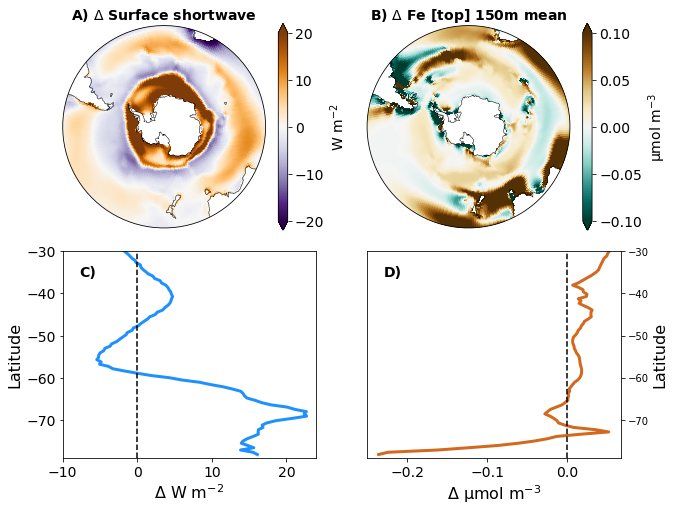

In [36]:
fig = plt.figure(figsize=(10,8))


#################################################################### plot SW map change
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('A) ${\Delta}$ Surface shortwave', fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_2090s['SHF_QSW'] - ensemble_mean_1920s['SHF_QSW'])
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-20, vmax=20, 
                 cmap='PuOr_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='W m$^{-2}$',size=14)
cbar1.ax.tick_params(labelsize=14)

################################################################### plot Fe change map
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('B) ${\Delta}$ Fe [top] 150m mean',fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = adjust_pop_grid(lons, lats, (ensemble_mean_2090s.Fe_avg_150m- ensemble_mean_1920s.Fe_avg_150m) * 1000.)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lon, lat, 
                 field, 
                 vmin=-0.1, vmax=0.1, 
                 #vmin=0.000001,vmax=0.0001,
                 cmap='BrBG_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='µmol m$^{-3}$',size=14)
cbar1.ax.tick_params(labelsize=14)

################################# zonal SW change
ax = fig.add_subplot(2,2,3)

ax.set_ylim(-79,-30)
ax.set_xlim(-10,24)
ax.set_title('C)', x=0.1, y=0.85, fontsize=14,fontweight='bold')
ax.plot(zonal_2090s['SHF_QSW']-zonal_1920s['SHF_QSW'],lats_zonal,  label='surface SW', linewidth=3, color='dodgerblue')
plt.axvline(x=0,color='black',linestyle='--')
ax.set_ylabel(ylabel='Latitude',fontsize=16)
ax.set_xlabel(xlabel='${\Delta}$ W m$^{-2}$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='x', nbins=4)

### SW light
ax = fig.add_subplot(2,2,4)

ax.set_ylim(-79,-30)
#ax.set_xlim(-10,24)
ax.set_title('D)', x=0.1, y=0.85, fontsize=14,fontweight='bold')
ax.plot(zonal_2090s['Fe_avg_150m']*1000.-zonal_1920s['Fe_avg_150m']*1000.,lats_zonal,  label='[Fe]', linewidth=3, color='chocolate')
plt.axvline(x=0,color='black',linestyle='--')
ax.set_ylabel(ylabel='Latitude',fontsize=16)
ax.set_xlabel(xlabel='${\Delta}$ µmol m$^{-3}$',fontsize=16) #or nM!!
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='x', nbins=4)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right();


fig.subplots_adjust(hspace=0.1)


fig.savefig('/glade/work/kristenk/figs/change_maps_zonals_in_SW_Fe.png', bbox_inches='tight', dpi=300, format='png');


### Read in masks

In [30]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

In [31]:
ACC_values_ds_1920s = xr.Dataset()
ACC_values_ds_1990s = xr.Dataset()
ACC_values_ds_2090s = xr.Dataset()


for var in variables:
    print(var)
    masked = ensemble_mean_1920s[var].where(ds_masks.ACC_mask==1.)
    ACC_values_ds_1920s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_1990s[var].where(ds_masks.ACC_mask==1.)
    ACC_values_ds_1990s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_2090s[var].where(ds_masks.ACC_mask==1.)
    ACC_values_ds_2090s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

Fe_avg_150m
SHF_QSW
NCP
Fe_FLUX_IN_100m
Bio_Fe_uptake


In [37]:
ACC_values_ds_1920s

<xarray.Dataset>
Dimensions:          ()
Data variables:
    Fe_avg_150m      float64 0.0001878
    SHF_QSW          float64 106.5
    NCP              float64 8.666
    Fe_FLUX_IN_100m  float64 41.85
    Bio_Fe_uptake    float64 4.218e-05

In [32]:
SIZ_values_ds_1920s = xr.Dataset()
SIZ_values_ds_1990s = xr.Dataset()
SIZ_values_ds_2090s = xr.Dataset()


for var in variables:
    print(var)
    masked = ensemble_mean_1920s[var].where(ds_masks.SIZ_mask==1.)
    SIZ_values_ds_1920s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_1990s[var].where(ds_masks.SIZ_mask==1.)
    SIZ_values_ds_1990s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_2090s[var].where(ds_masks.SIZ_mask==1.)
    SIZ_values_ds_2090s[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

Fe_avg_150m
SHF_QSW
NCP
Fe_FLUX_IN_100m
Bio_Fe_uptake


### NCP versus [Fe]

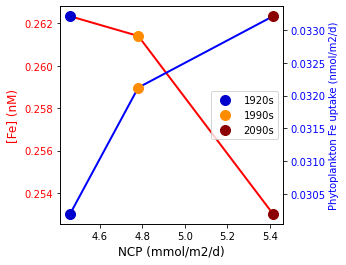

In [33]:
fig = plt.figure(figsize=(4,4))

### diat frac
ax = fig.add_subplot(1,1,1)

# ax.set_ylim(-79,-30)
# ax.set_xlim(-0.1,0.1)
#ax.set_title('b)${\Delta}$ Change diatom fraction', x=0.4)
#ax.plot(zonal_1990s['diat_frac']-zonal_1920s['diat_frac'],lats_zonal,  label='1990s', linewidth=3)
ax.scatter(SIZ_values_ds_1920s['NCP'],SIZ_values_ds_1920s['Fe_avg_150m']*1000.,  label='1920s', color='mediumblue',s=100,zorder=2)
ax.scatter(SIZ_values_ds_1990s['NCP'],SIZ_values_ds_1990s['Fe_avg_150m']*1000.,  label='1990s', color='darkorange',s=100,zorder=2)
ax.scatter(SIZ_values_ds_2090s['NCP'],SIZ_values_ds_2090s['Fe_avg_150m']*1000.,  label='2090s', color='darkred',s=100,zorder=2)

ax.plot([SIZ_values_ds_1920s['NCP'],SIZ_values_ds_1990s['NCP'],SIZ_values_ds_2090s['NCP']],
        [SIZ_values_ds_1920s['Fe_avg_150m']*1000.,SIZ_values_ds_1990s['Fe_avg_150m']*1000.,SIZ_values_ds_2090s['Fe_avg_150m']*1000.],  
         color='red',linewidth=2,zorder=1)

ax.set_ylabel(ylabel='[Fe] (nM)',fontsize=12,color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_xlabel(xlabel='NCP (mmol/m2/d)',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)


ax2=ax.twinx()
ax2.scatter(SIZ_values_ds_1920s['NCP'],SIZ_values_ds_1920s['Bio_Fe_uptake']*1000.,  label='1920s', color='mediumblue',s=100,zorder=2)
ax2.scatter(SIZ_values_ds_1990s['NCP'],SIZ_values_ds_1990s['Bio_Fe_uptake']*1000.,  label='1990s', color='darkorange',s=100,zorder=2)
ax2.scatter(SIZ_values_ds_2090s['NCP'],SIZ_values_ds_2090s['Bio_Fe_uptake']*1000.,  label='2090s', color='darkred',s=100,zorder=2)

ax2.plot([SIZ_values_ds_1920s['NCP'],SIZ_values_ds_1990s['NCP'],SIZ_values_ds_2090s['NCP']],
        [SIZ_values_ds_1920s['Bio_Fe_uptake']*1000.,SIZ_values_ds_1990s['Bio_Fe_uptake']*1000.,SIZ_values_ds_2090s['Bio_Fe_uptake']*1000.],  
         color='blue',linewidth=2,zorder=1)

ax2.set_ylabel('Phytoplankton Fe uptake (nmol/m2/d)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2.legend(loc="center right");

#plt.locator_params(axis='x', nbins=4)

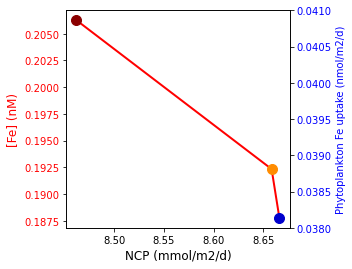

In [34]:
fig = plt.figure(figsize=(4,4))

### diat frac
ax = fig.add_subplot(1,1,1)

# ax.set_ylim(-79,-30)
# ax.set_xlim(-0.1,0.1)
#ax.set_title('b)${\Delta}$ Change diatom fraction', x=0.4)
#ax.plot(zonal_1990s['diat_frac']-zonal_1920s['diat_frac'],lats_zonal,  label='1990s', linewidth=3)
ax.scatter(ACC_values_ds_1920s['NCP'],ACC_values_ds_1920s['Fe_avg_150m']*1000.,  label='1920s', color='mediumblue',s=100,zorder=2)
ax.scatter(ACC_values_ds_1990s['NCP'],ACC_values_ds_1990s['Fe_avg_150m']*1000.,  label='1990s', color='darkorange',s=100,zorder=2)
ax.scatter(ACC_values_ds_2090s['NCP'],ACC_values_ds_2090s['Fe_avg_150m']*1000.,  label='2090s', color='darkred',s=100,zorder=2)

ax.plot([ACC_values_ds_1920s['NCP'],ACC_values_ds_1990s['NCP'],ACC_values_ds_2090s['NCP']],
        [ACC_values_ds_1920s['Fe_avg_150m']*1000.,ACC_values_ds_1990s['Fe_avg_150m']*1000.,ACC_values_ds_2090s['Fe_avg_150m']*1000.],  
         color='red',linewidth=2,zorder=1)

ax.set_ylabel(ylabel='[Fe] (nM)',fontsize=12,color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_xlabel(xlabel='NCP (mmol/m2/d)',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)


ax2=ax.twinx()
ax2.set_ylim(0.038,0.041)
ax2.scatter(ACC_values_ds_1920s['NCP'],ACC_values_ds_1920s['Bio_Fe_uptake']*1000.,  label='1920s', color='mediumblue',s=100,zorder=2)
ax2.scatter(ACC_values_ds_1990s['NCP'],ACC_values_ds_1990s['Bio_Fe_uptake']*1000.,  label='1990s', color='darkorange',s=100,zorder=2)
ax2.scatter(ACC_values_ds_2090s['NCP'],ACC_values_ds_2090s['Bio_Fe_uptake']*1000.,  label='2090s', color='darkred',s=100,zorder=2)

ax2.plot([ACC_values_ds_1920s['NCP'],ACC_values_ds_1990s['NCP'],ACC_values_ds_2090s['NCP']],
        [ACC_values_ds_1920s['Bio_Fe_uptake']*1000.,ACC_values_ds_1990s['Bio_Fe_uptake']*1000.,ACC_values_ds_2090s['Bio_Fe_uptake']*1000.],  
         color='blue',linewidth=2,zorder=1)

ax2.set_ylabel('Phytoplankton Fe uptake (nmol/m2/d)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

#ax2.legend(loc="center right");

#plt.locator_params(axis='x', nbins=4)

## Put these together

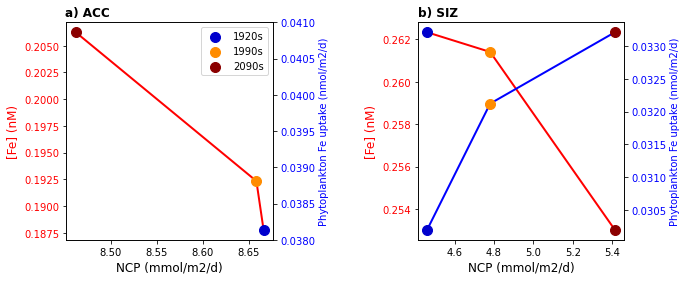

In [35]:
fig = plt.figure(figsize=(10,4))

################################################ ACC

ax = fig.add_subplot(1,2,1)

# ax.set_ylim(-79,-30)
# ax.set_xlim(-0.1,0.1)
ax.set_title('a) ACC', x=0.1,fontweight='bold')
ax.scatter(ACC_values_ds_1920s['NCP'],ACC_values_ds_1920s['Fe_avg_150m']*1000.,  label='1920s', color='mediumblue',s=100,zorder=2)
ax.scatter(ACC_values_ds_1990s['NCP'],ACC_values_ds_1990s['Fe_avg_150m']*1000.,  label='1990s', color='darkorange',s=100,zorder=2)
ax.scatter(ACC_values_ds_2090s['NCP'],ACC_values_ds_2090s['Fe_avg_150m']*1000.,  label='2090s', color='darkred',s=100,zorder=2)

ax.plot([ACC_values_ds_1920s['NCP'],ACC_values_ds_1990s['NCP'],ACC_values_ds_2090s['NCP']],
        [ACC_values_ds_1920s['Fe_avg_150m']*1000.,ACC_values_ds_1990s['Fe_avg_150m']*1000.,ACC_values_ds_2090s['Fe_avg_150m']*1000.],  
         color='red',linewidth=2,zorder=1)

ax.set_ylabel(ylabel='[Fe] (nM)',fontsize=12,color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_xlabel(xlabel='NCP (mmol/m2/d)',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

ax.legend()
ax2=ax.twinx()
ax2.set_ylim(0.038,0.041)
ax2.scatter(ACC_values_ds_1920s['NCP'],ACC_values_ds_1920s['Bio_Fe_uptake']*1000.,  label='1920s', color='mediumblue',s=100,zorder=2)
ax2.scatter(ACC_values_ds_1990s['NCP'],ACC_values_ds_1990s['Bio_Fe_uptake']*1000.,  label='1990s', color='darkorange',s=100,zorder=2)
ax2.scatter(ACC_values_ds_2090s['NCP'],ACC_values_ds_2090s['Bio_Fe_uptake']*1000.,  label='2090s', color='darkred',s=100,zorder=2)

ax2.plot([ACC_values_ds_1920s['NCP'],ACC_values_ds_1990s['NCP'],ACC_values_ds_2090s['NCP']],
        [ACC_values_ds_1920s['Bio_Fe_uptake']*1000.,ACC_values_ds_1990s['Bio_Fe_uptake']*1000.,ACC_values_ds_2090s['Bio_Fe_uptake']*1000.],  
         color='blue',linewidth=2,zorder=1)

ax2.set_ylabel('Phytoplankton Fe uptake (nmol/m2/d)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

########################################################## SIZ

ax = fig.add_subplot(1,2,2)

# ax.set_ylim(-79,-30)
# ax.set_xlim(-0.1,0.1)
ax.set_title('b) SIZ', x=0.1,fontweight='bold')
ax.scatter(SIZ_values_ds_1920s['NCP'],SIZ_values_ds_1920s['Fe_avg_150m']*1000.,  label='1920s', color='mediumblue',s=100,zorder=2)
ax.scatter(SIZ_values_ds_1990s['NCP'],SIZ_values_ds_1990s['Fe_avg_150m']*1000.,  label='1990s', color='darkorange',s=100,zorder=2)
ax.scatter(SIZ_values_ds_2090s['NCP'],SIZ_values_ds_2090s['Fe_avg_150m']*1000.,  label='2090s', color='darkred',s=100,zorder=2)

ax.plot([SIZ_values_ds_1920s['NCP'],SIZ_values_ds_1990s['NCP'],SIZ_values_ds_2090s['NCP']],
        [SIZ_values_ds_1920s['Fe_avg_150m']*1000.,SIZ_values_ds_1990s['Fe_avg_150m']*1000.,SIZ_values_ds_2090s['Fe_avg_150m']*1000.],  
         color='red',linewidth=2,zorder=1)

ax.set_ylabel(ylabel='[Fe] (nM)',fontsize=12,color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_xlabel(xlabel='NCP (mmol/m2/d)',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)


ax2=ax.twinx()
ax2.scatter(SIZ_values_ds_1920s['NCP'],SIZ_values_ds_1920s['Bio_Fe_uptake']*1000.,  label='1920s', color='mediumblue',s=100,zorder=2)
ax2.scatter(SIZ_values_ds_1990s['NCP'],SIZ_values_ds_1990s['Bio_Fe_uptake']*1000.,  label='1990s', color='darkorange',s=100,zorder=2)
ax2.scatter(SIZ_values_ds_2090s['NCP'],SIZ_values_ds_2090s['Bio_Fe_uptake']*1000.,  label='2090s', color='darkred',s=100,zorder=2)

ax2.plot([SIZ_values_ds_1920s['NCP'],SIZ_values_ds_1990s['NCP'],SIZ_values_ds_2090s['NCP']],
        [SIZ_values_ds_1920s['Bio_Fe_uptake']*1000.,SIZ_values_ds_1990s['Bio_Fe_uptake']*1000.,SIZ_values_ds_2090s['Bio_Fe_uptake']*1000.],  
         color='blue',linewidth=2,zorder=1)

ax2.set_ylabel('Phytoplankton Fe uptake (nmol/m2/d)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

#ax2.legend(loc="bottom center")

plt.subplots_adjust(wspace=0.7)

fig.savefig('/glade/work/kristenk/figs/Fe_Feuptake_NCP.png', bbox_inches='tight', dpi=300, format='png');

